In [1]:
import xarray as xr
import Rbeast as rb
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle as pk
import seaborn as sns

mpl.rcParams["figure.figsize"] = (16, 10)
dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/"
Fig_dir = dir + "manuscript1/figures/"


Initialization done!


In [2]:
percent = xr.open_dataset(dir + "data/processed_data/percent_cover/percent_cover.nc")[
    "__xarray_dataarray_variable__"
]
# changed_pixels_mask = xr.open_dataarray(
#     dir + "data/processed_data/noaa_nc/lai_fapar/trend/changed_pixels.nc"
# )

# CT is the dataset that includes the confusion table for all the changed pixels (changed_pixels_mask.sum())
ct = xr.open_dataset(
    dir + "data/processed_data/confusion_tables/ct_all_years_corrected.nc"
)
pix_id = ct["PIX_INDEX"]
ctn = ct["NORMALIZED_CONFUSION"] * 100
dlcc = ct["DLCC"]  #
conf = ct["CONFUSION"]


Run the Rbest on the LAI_max


In [6]:
lai_max_file = "lai_max_norm_included_overlap.nc"
ndvi_max_file =    "ndvi_max_norm_included.nc"
# trend_file = "lai_max_trend.nc"
# var_name = "lai_max"

# arr is an empty matrix where pixels valuses are associated with IDs in ct dataset
arr = np.arange(0, 448 * 1348).reshape(448, 1348, order="F")
t = pd.date_range(start="1985", end="2014", freq="A-Dec").year  # Time range

lai_max = xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/" + lai_max_file
)
ndvi_max = xr.open_dataarray(dir + "data/processed_data/landsat/trend/" + ndvi_max_file)


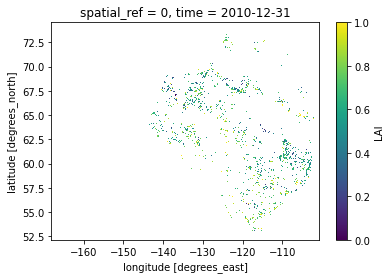

In [9]:
lai_max.isel(time=25).plot()


Run Rbeast on LAI and NDVI


In [4]:
# Rbeast LAI
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
)
season = "none"
out_lai = rb.beast123(lai_max.values, metadata, prior, mcmc, extra)

# Rbeast NDVI
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
)
season = "none"
out_ndvi = rb.beast123(ndvi_max.values, metadata, prior, mcmc, extra)


On the first run, check the CPU instruction set ... 

15
CPU Vendor:
    AMD         = No
    Intel       = Yes
 
OS Features:
    OS AVX      = Yes
    OS AVX512   = No

Hardware Features:
    MMX         = Yes
    x64         = Yes
    ABM         = Yes
    RDRAND      = Yes
    RDSEED      = No
    BMI1        = Yes
    BMI2        = Yes
    ADX         = No
    MPX         = No
    PREFETCHW   = No
    PREFETCHWT1 = No
    RDPID       = No
    GFNI        = No
    VAES        = No

SIMD: 128-bit
    SSE         = Yes
    SSE2        = Yes
    SSE3        = Yes
    SSSE3       = Yes
    SSE4a       = No
    SSE4.1      = Yes
    SSE4.2      = Yes
    AES-NI      = Yes
    SHA         = No

SIMD: 256-bit
    AVX         = Yes
    XOP         = No
    FMA3        = Yes
    FMA4        = No
    AVX2        = Yes

SIMD: 512-bit
    AVX512-F         = No
    AVX512-CD        = No
    AVX512-PF        = No
    AVX512-ER        = No
    AVX512-VL        = No
    AVX512-BW        = No
    A

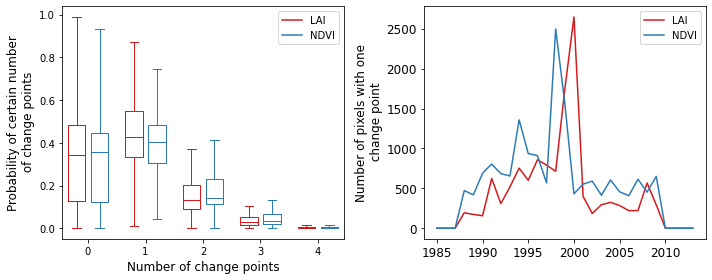

In [5]:
def set_box_color(bp, color):
    plt.setp(bp["boxes"], color=color)
    plt.setp(bp["whiskers"], color=color)
    plt.setp(bp["caps"], color=color)
    plt.setp(bp["medians"], color=color)


cp_lai = out_lai.trend.cp  # the most possible changepoint locations in the trend
cpPr_lai = out_lai.trend.cpPr
ncpPr_lai = (
    out_lai.trend.ncpPr
)  # probability distribution of having a certain number of trend changepoints
cpOccPr_lai = out_lai.trend.cpOccPr

cp_ndvi = out_ndvi.trend.cp  # the most possible changepoint locations in the trend
cpPr_ndvi = out_ndvi.trend.cpPr
ncpPr_ndvi = (
    out_ndvi.trend.ncpPr
)  # probability distribution of having a certain number of trend changepoints
cpOccPr_ndvi = out_ndvi.trend.cpOccPr

ticks = ["0", "1", "2", "3", "4"]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in range(5):
    a = ncpPr_lai[i, :, :]
    b = ncpPr_ndvi[i, :, :]
    f1 = axs[0].boxplot(
        a[~np.isnan(a)], positions=np.array([i]) * 2 - 0.4, sym="", widths=0.6
    )
    f2 = axs[0].boxplot(
        b[~np.isnan(b)], positions=np.array([i]) * 2 + 0.4, sym="", widths=0.6
    )
    set_box_color(f1, "#D7191C")  # colors are from http://colorbrewer2.org/
    set_box_color(f2, "#2C7BB6")

# draw temporary red and blue lines and use them to create a legend
axs[0].plot([], c="#D7191C", label="LAI")
axs[0].plot([], c="#2C7BB6", label="NDVI")
axs[0].legend()

axs[0].set_xlabel("Number of change points", fontsize=12)
axs[0].set_ylabel("Probability of certain number\n of change points", fontsize=12)
axs[0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

cps_lai = []
cps_ndvi = []
for i in np.arange(1985, 2014):
    cps_lai.append((cp_lai[0] == i).sum())
    cps_ndvi.append((cp_ndvi[0] == i).sum())

axs[1].plot(t, np.array(cps_lai), color="#D7191C")
axs[1].plot(t, np.array(cps_ndvi), color="#2C7BB6")
axs[1].set_ylabel("Number of pixels with one\n change point", fontsize=12)
axs[1].plot([], c="#D7191C", label="LAI")
axs[1].plot([], c="#2C7BB6", label="NDVI")
axs[1].legend()


plt.tight_layout()
plt.savefig(Fig_dir + "ProbabiltyCP.png")


In [7]:
ncp_median = out_lai.trend.ncp_median
ncp1 = np.argwhere(ncp_median == 1)
cp1 = np.squeeze(cp_lai[0, :, :])  # The most possible change point year
occ_mat = np.zeros((10, 10, 448 * 1348))
ct_percent_mat = np.zeros((10, 10, 448 * 1348))
ct_percent_mat[:] = np.nan
percent_mat = np.zeros((10, 10, 448 * 1348))
percent_mat[:] = np.nan
ui = np.triu_indices(10, k=1)
li = np.tril_indices(10, k=-1)
no_lcc = 0
counter = 0

# Go over all pixels and drive some relvant Rbeast info for changed pixles
for i in np.arange(0, cp1.shape[0]):
    for j in np.arange(0, cp1.shape[1]):
        # skip if no change point detected
        if np.isnan(cp1[i, j]):
            continue

        cp_time = int(cp1[i, j])  # Year with the highest possible change point
        idx = arr[i, j]
        id = np.where(pix_id.isel(time=0).values == idx)[0]

        # Select the confusion matrix associated to i and j pixel
        ctn_sel = ctn.isel(ID=id).sel(time=str(cp_time)).squeeze().values

        np.fill_diagonal(ctn_sel, 0)

        I_max = np.unravel_index(ctn_sel.argmax(), ctn_sel.shape)
        if I_max == (0, 0):
            no_lcc += 1
            continue
        abs_lcc = abs(ctn_sel[ui] - ctn_sel[li])
        net_lcc = abs_lcc.sum()

        if net_lcc < 5:
            continue
        percent_mat[I_max + (idx,)] = net_lcc
        # I_max_reversed = I_max[::-1]
        max_ct = np.argmax(abs_lcc)

        # max of upper & lower confusion matrix triangles
        ct_percent_mat[I_max + (idx,)] = max(
            ctn_sel[li[0][max_ct], li[1][max_ct]], ctn_sel[ui[0][max_ct], ui[1][max_ct]]
        )
        occ_mat[I_max + (idx,)] += 1

        counter = counter + 1

names = [
    "EF",
    "DF",
    "shrub",
    "Herb",
    "sparse",
    "Barren",
]
occurance = occ_mat.sum(axis=2)
occurance_percent = 100 * occurance / occurance.sum()
occurance[np.diag_indices(10, 2)] = np.nan
occurance_percent[np.diag_indices(10, 2)] = np.nan

df_lai = xr.DataArray(
    data=occurance_percent[0:6, 0:6],
    dims=["LC_t1", "LC_t2"],
    coords={"LC_t1": names, "LC_t2": names},
)
percent_mat_data_lai = percent_mat[~np.isnan(percent_mat)]
percent_mat_data_df_lai = xr.DataArray(percent_mat_data_lai, dims=["ID"])
df_lai.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/Rbeast/dfRbeast_LAIMax.nc"
)
percent_mat_data_df_lai.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/Rbeast/percent_mat_LAIMax.nc"
)


In [8]:
ncp_median = out_ndvi.trend.ncp_median
ncp1 = np.argwhere(ncp_median == 1)
cp1 = np.squeeze(cp_ndvi[0, :, :])  # The most possible change point year
occ_mat = np.zeros((10, 10, 448 * 1348))
ct_percent_mat = np.zeros((10, 10, 448 * 1348))
ct_percent_mat[:] = np.nan
percent_mat = np.zeros((10, 10, 448 * 1348))
percent_mat[:] = np.nan
ui = np.triu_indices(10, k=1)
li = np.tril_indices(10, k=-1)
no_lcc = 0
counter = 0

# Go over all pixels and drive some relvant Rbeast info for changed pixles
for i in np.arange(0, cp1.shape[0]):
    for j in np.arange(0, cp1.shape[1]):
        # skip if no change point detected
        if np.isnan(cp1[i, j]):
            continue

        cp_time = int(cp1[i, j])  # Year with the highest possible change point
        idx = arr[i, j]
        id = np.where(pix_id.isel(time=0).values == idx)[0]

        # Select the confusion matrix associated to i and j pixel
        ctn_sel = ctn.isel(ID=id).sel(time=str(cp_time)).squeeze().values

        np.fill_diagonal(ctn_sel, 0)

        I_max = np.unravel_index(ctn_sel.argmax(), ctn_sel.shape)
        if I_max == (0, 0):
            no_lcc += 1
            continue
        abs_lcc = abs(ctn_sel[ui] - ctn_sel[li])
        net_lcc = abs_lcc.sum()

        if net_lcc < 5:
            continue
        percent_mat[I_max + (idx,)] = net_lcc
        # I_max_reversed = I_max[::-1]
        max_ct = np.argmax(abs_lcc)

        # max of upper & lower confusion matrix triangles
        ct_percent_mat[I_max + (idx,)] = max(
            ctn_sel[li[0][max_ct], li[1][max_ct]], ctn_sel[ui[0][max_ct], ui[1][max_ct]]
        )
        occ_mat[I_max + (idx,)] += 1

        counter = counter + 1

names = [
    "EF",
    "DF",
    "shrub",
    "Herb",
    "sparse",
    "Barren",
]
occurance = occ_mat.sum(axis=2)
occurance_percent = 100 * occurance / occurance.sum()
occurance[np.diag_indices(10, 2)] = np.nan
occurance_percent[np.diag_indices(10, 2)] = np.nan

df_ndvi = xr.DataArray(
    data=occurance_percent[0:6, 0:6],
    dims=["LC_t1", "LC_t2"],
    coords={"LC_t1": names, "LC_t2": names},
)
percent_mat_data_ndvi = percent_mat[~np.isnan(percent_mat)]
percent_mat_data_df_ndvi = xr.DataArray(percent_mat_data_ndvi, dims=["ID"])
df_ndvi.to_netcdf(dir + "data/processed_data/landsat/Rbeast/dfRbeast_LAIMax.nc")
percent_mat_data_df_lai.to_netcdf(
    dir + "data/processed_data/landsat/Rbeast/percent_mat_LAIMax.nc"
)


Text(0.5, 1.0, 'Peak NDVI')

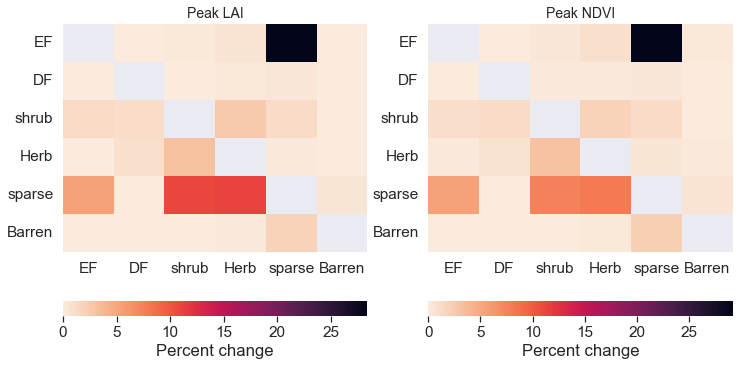

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.set(font_scale=1.4)
sns.heatmap(
    df_lai,
    ax=axs[0],
    robust=True,
    xticklabels=names,
    yticklabels=names,
    cmap="rocket_r",
    # cmap= cmap,
    # annot=True,
    cbar_kws={"label": "Percent change", "location": "bottom"},
)
axs[0].set_title("Peak LAI", fontsize=14)
sns.heatmap(
    df_ndvi,
    ax=axs[1],
    robust=True,
    xticklabels=names,
    yticklabels=names,
    cmap="rocket_r",
    # annot=True,
    cbar_kws={"label": "Probability of", "location": "bottom"},
)
axs[1].set_title("Peak NDVI", fontsize=14)


In [67]:
mean_lcc_lai = percent_mat_data_df_lai.mean()
std_lcc_lai = percent_mat_data_df_lai.std()
mean_lcc_ndvi = percent_mat_data_df_ndvi.mean()
std_lcc_ndvi = percent_mat_data_df_ndvi.std()
print(
    "Mean LULCC for a change point in LAI trend happens is:"
    + str(mean_lcc_lai.round().values)
    + " and std is:"
    + str(std_lcc_lai.round().values)
)
print(
    "Mean LULCC for a change point in LAI trend happens is:"
    + str(mean_lcc_ndvi.round().values)
    + " and std is:"
    + str(std_lcc_ndvi.round().values)
)


Mean LULCC for a change point in LAI trend happens is:13.0 and std is:11.0
Mean LULCC for a change point in LAI trend happens is:14.0 and std is:10.0
